In [4]:
# Thoomas Goldman 2023
# DOLPHINN
import sys
import os
import matplotlib.pyplot as plt

#Get the absolute path of the current scriptf
current_path = os.path.dirname(os.path.abspath('__file__'))
dolphinn_path = os.path.join(current_path, '..')
sys.path.append(dolphinn_path)

from DOLPHINN.pinn import DOLPHINN 
from DOLPHINN.dynamics import TwoBodyProblemRadialNonDimensionalControl
from DOLPHINN.output_layers import InitialFinalStateLayer_Radial
from DOLPHINN.training import Scheduler, Restarter, Restorer
from DOLPHINN.objectives import OptimalFuel
from DOLPHINN.metrics import FinalDr, FinalDv
from DOLPHINN.callbacks import StoreAnimationData

from DOLPHINN import plotting
from DOLPHINN import utils

import numpy as np
import pickle

In [5]:
mu = 1.32712440042e20 # SUN
m = 100 #Spacecraft mass
AU = 1.5e11 #EARTH-SUN
a = 10
umax = 1
isp = 2500

rp = AU
ra = 1.5*AU

e = (ra - rp)/(ra + rp)
sma = (rp + ra)/2

# Initial state
r0 = AU
vr0 = 0
vt0 = np.sqrt(mu/r0)
initial_state = np.array([r0, vr0, vt0])

# Final state
rfinal = 1.5*AU
vr_final = 0
vt_final = np.sqrt(mu/rfinal)
final_state = np.array([rfinal, vr_final, vt_final])

# Non dimensionalize
length_scale = AU
time_scale = AU / vt0

initial_state[:1] = initial_state[:1]/length_scale
initial_state[1:] = initial_state[1:]*time_scale/length_scale

final_state[:1] = final_state[:1]/length_scale
final_state[1:] = final_state[1:]*time_scale/length_scale

# Integration times
period = 2*np.pi*np.sqrt(sma**3/mu)
t0 = 0
tfinal = 1.5*period
N = 200

# Network architecture
input_dimension = 1
output_dimension = 5
neurons = 5
hidden_layers = 3
layer_size = [input_dimension] + [[neurons]*output_dimension] * hidden_layers + [output_dimension]

data = {"initial_state": initial_state,
        "final_state": final_state,
        "mu": mu,
        "m": m,
        "a": a,
        "umax": umax,
        "isp": isp,
        "length_scale": length_scale,
        "time_scale": time_scale,
        "t0": t0,
        "tfinal": tfinal/time_scale,
        "architecture": layer_size,
        "activation": "sin",
        "N_train": N,
        "N_boundary": 2,
        "N_test": N,
        "sampler": "perturbed_uniform_tf"}

### Grid search template (here for the weights) 

In [6]:
base_folder = "../data/Optimisation/LVLH/mars_weights_grid_1_5_revolv/"
weigths = np.geomspace(1e-11, 1e-2, 10)

for i, weigth in enumerate(weigths):
    
    print(f"[DOLPHINN] Weight: {weigth} ({i}/{len(weigths)})")
    
    problem = DOLPHINN(data,
                        "TwoBodyProblemRadialNonDimensionalControl",
                        output_transform = "InitialFinalStateLayer_Radial_tanh",
                        objective = "OptimalFuel", 
                        display_every = 1000,
                        verbose = False)

    restarter = Restarter([(1e-2, 3000)], loss_weigths = [1, 1, 1, weigth])
    schedule = Scheduler([(1e-3, 5000), (1e-4, 15000)],
                         loss_weigths= [1, 1, 1, weigth]
                        )
    
    problem.train([restarter, schedule])
    problem.store(base_folder + f"weight_{i}/")

[DOLPHINN] Weight: 1e-11 (0/10)
'compile' took 0.002764 s

Training model...

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
'train' took 10.153118 s

'compile' took 0.001359 s

Training model...

'train' took 12.041069 s

'compile' took 0.001562 s

Training model...

'train' took 11.585664 s

'compile' took 0.001320 s

Training model...

'train' took 12.420949 s

'compile' took 0.001275 s

Training model...

'train' took 8.490742 s

'compile' took 0.001384 s

Training model...

'train' took 12.688380 s

'compile' took 0.001633 s

Training model...

'train' took 13.484365 s

'compile' took 0.001392 s

Training model...

'train' took 12.614485 s

'compile' took 0.001294 s

Training model...

'train' took 9.120758 s

'compile' took 0.001130 s

Training model...

'train' took 12.722074 s

'compile' took 0.001239 s

Training model...

'tr

## Single training template

In [4]:
# Create problem
animation = StoreAnimationData(path="../data/Optimisation/LVLH/mars_1_5_revolv2/animation_data/", 
                              period=100)

problem = DOLPHINN(data,
                    "TwoBodyProblemRadialNonDimensionalControl",
                    output_transform = "InitialFinalStateLayer_Radial_tanh",
                    objective = "OptimalFuel", 
                    metrics = [FinalDr, FinalDv], 
                    callbacks = [animation], 
                    display_every = 1000,
                    verbose = True)

oweigth = 1e-7
restarter = Restarter([(1e-2, 3000)], loss_weigths = [1, 1, 1, oweigth])
schedule = Scheduler([(1e-3, 5000), (1e-4, 10000), (5e-3, 4000), (1e-4, 5000)],
                     loss_weigths= [1, 1, 1, oweigth]
                    )
problem.train([restarter, schedule])

[DOLPHINN] Using time-dependent random seed: 20230702233619

[DOLPHINN] Training with procedure: Restarter

[RESTARTER] Initialisation attempt: 1
Compiling model...
'compile' took 0.002802 s

Training model...

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Step      Train loss                                  Test loss                                   Test metric             
0         [5.76e+00, 2.69e+05, 4.01e+00, 1.43e-04]    [1.46e+00, 8.52e+05, 1.36e+00, 1.42e-04]    [2.81e-01, 2.81e-01]    
[DOLPHINN] Error occured in metric: `y` must contain only finite values.
[DOLPHINN] Error occured in metric: `y` must contain only finite values.
1000      [nan, nan, nan, nan]                        [nan, nan, nan, nan]                        [nan, nan]              
[DOLPHINN] Error occured in metric: `y` must contain only finite values.


### Additional Training

In [14]:
schedule = Scheduler([(1e-4, 5000)],
                     loss_weigths= [1, 1, 1, oweigth]
                    )
problem.train(schedule)


[DOLPHINN] Training with procedure: Scheduler

Compiling model...
'compile' took 0.095732 s

Training model...

Step      Train loss                                  Test loss                                   Test metric             
23000     [4.01e-08, 7.37e-08, 4.25e-08, 2.32e-06]    [3.86e-08, 7.20e-08, 4.31e-08, 2.30e-06]    [3.39e-02, 3.39e-02]    
24000     [4.11e-08, 7.06e-08, 3.88e-08, 2.32e-06]    [4.07e-08, 6.72e-08, 3.94e-08, 2.30e-06]    [3.30e-02, 3.30e-02]    
25000     [3.77e-08, 6.90e-08, 4.01e-08, 2.31e-06]    [3.69e-08, 6.73e-08, 4.07e-08, 2.29e-06]    [3.34e-02, 3.34e-02]    
26000     [3.46e-08, 7.46e-08, 4.50e-08, 2.30e-06]    [3.48e-08, 7.12e-08, 4.51e-08, 2.28e-06]    [3.36e-02, 3.36e-02]    
27000     [3.66e-08, 6.81e-08, 3.96e-08, 2.30e-06]    [3.64e-08, 6.68e-08, 3.84e-08, 2.28e-06]    [3.22e-02, 3.22e-02]    
28000     [3.28e-08, 6.25e-08, 3.76e-08, 2.29e-06]    [3.31e-08, 6.12e-08, 3.78e-08, 2.27e-06]    [3.29e-02, 3.29e-02]    
[DOLPHINN] Saved animation

In [16]:
utils.print_config(problem.config)


 ==================== Config Content ====================

----------Functions----------
dynamics                       TwoBodyProblemRadialNonDimensionalControl
input_transform                NoneType
output_transform               InitialFinalStateLayer_Radial_tanh
objective                      OptimalFuel

----------Problem----------
metric_1                       FinalDr
metric_2                       FinalDv
initial_state                  [1.0, 0.0, 1.0]
final_state                    [1.5, 0.0, 0.816496580927726]
mu                             1.32712440042e+20
m                              100
a                              10
umax                           1
isp                            2500
length_scale                   150000000000.0
time_scale                     5042908.305393074
t0                             0
tfinal                         13.17152762070136

----------Network----------
architecture                   [1, [5, 5, 5, 5, 5], [5, 5, 5, 5, 5], [5, 5, 5, 5

[DOLPHINN] Setting up the TUDAT simulation
[DOLPHINN] Guidance is internal!
[DOLPHINN] Start Integrating
[DOLPHINN] Finished integrating in 0.06 s


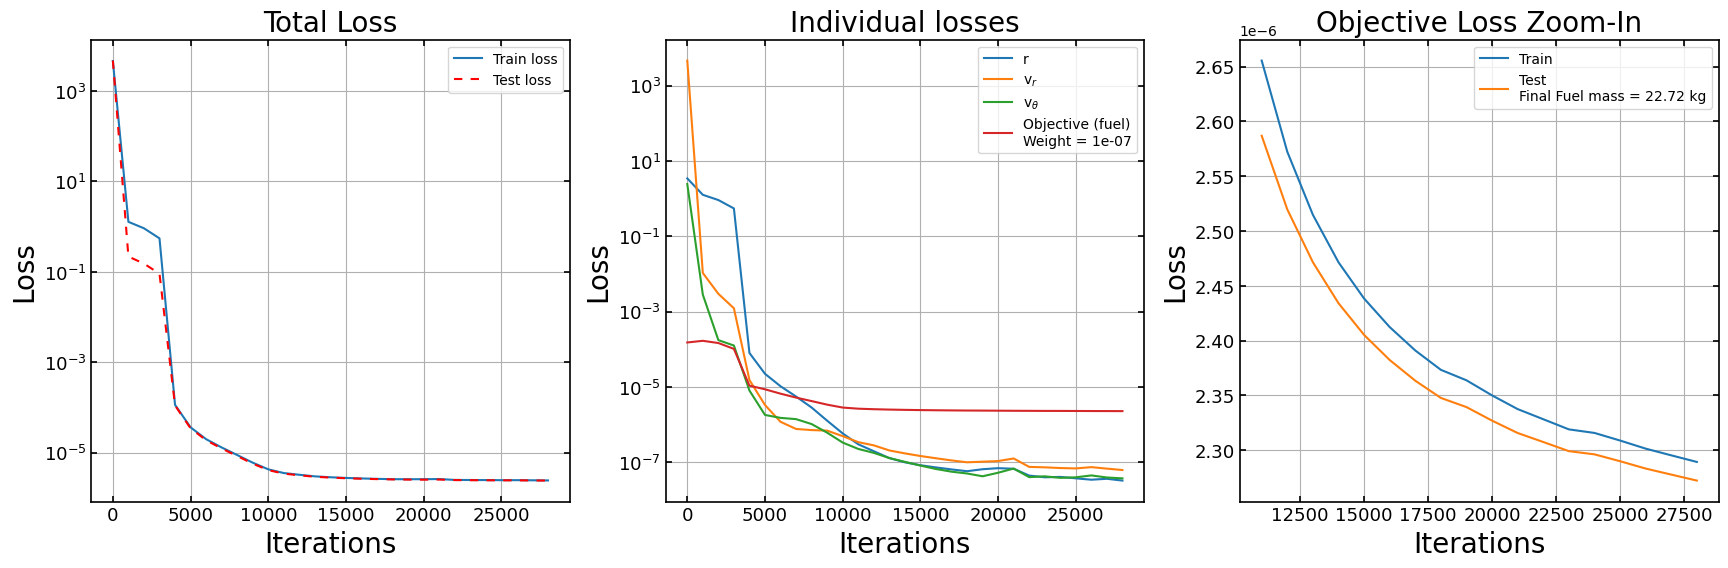

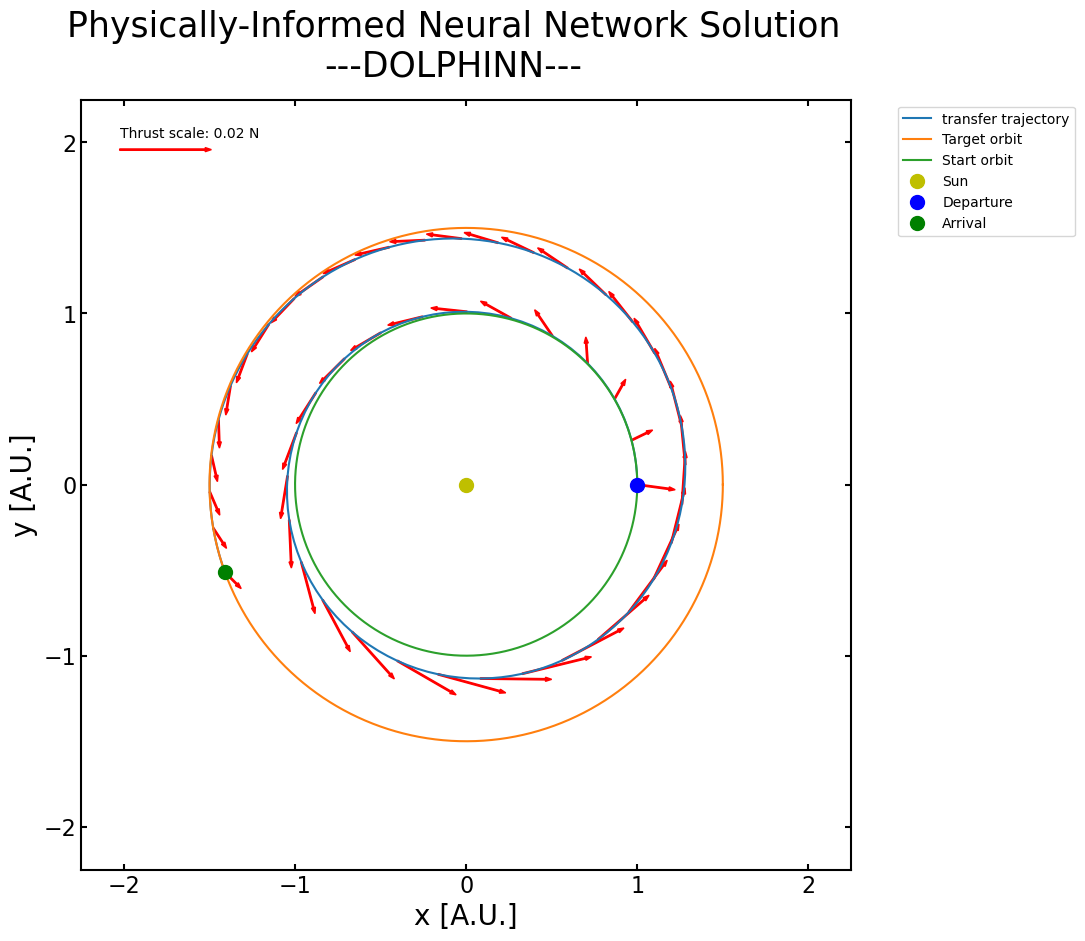

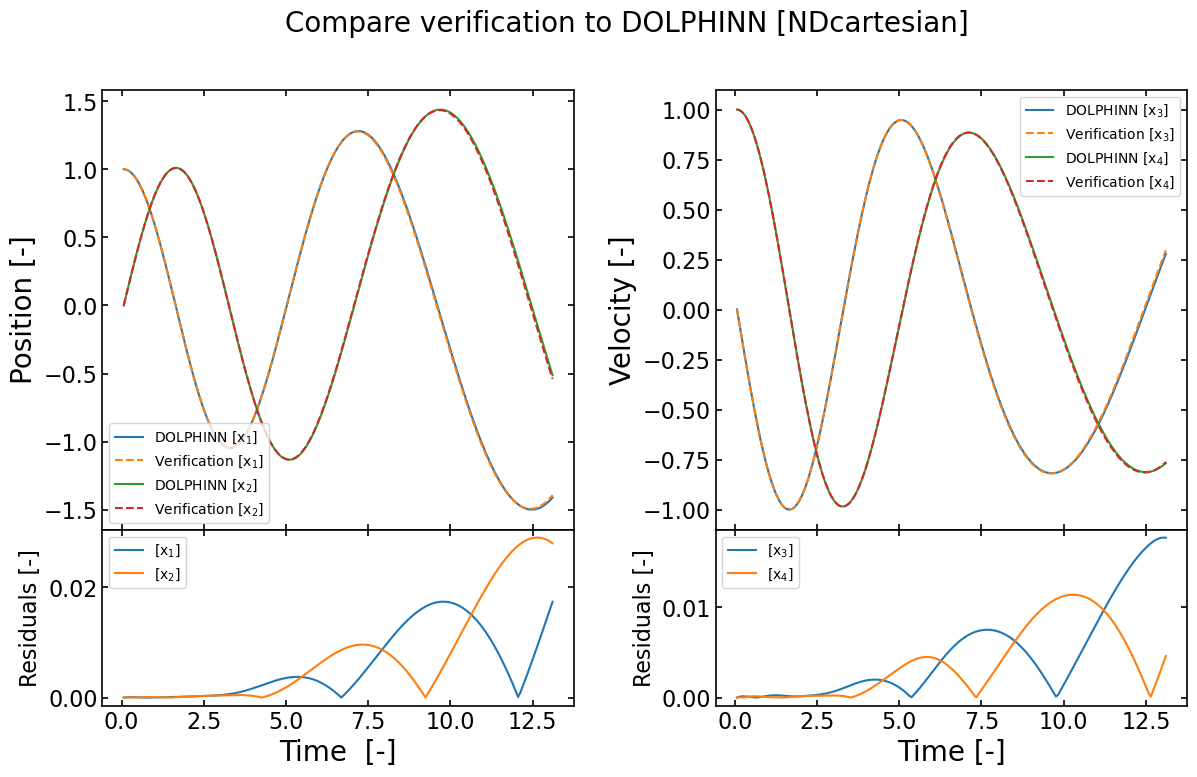

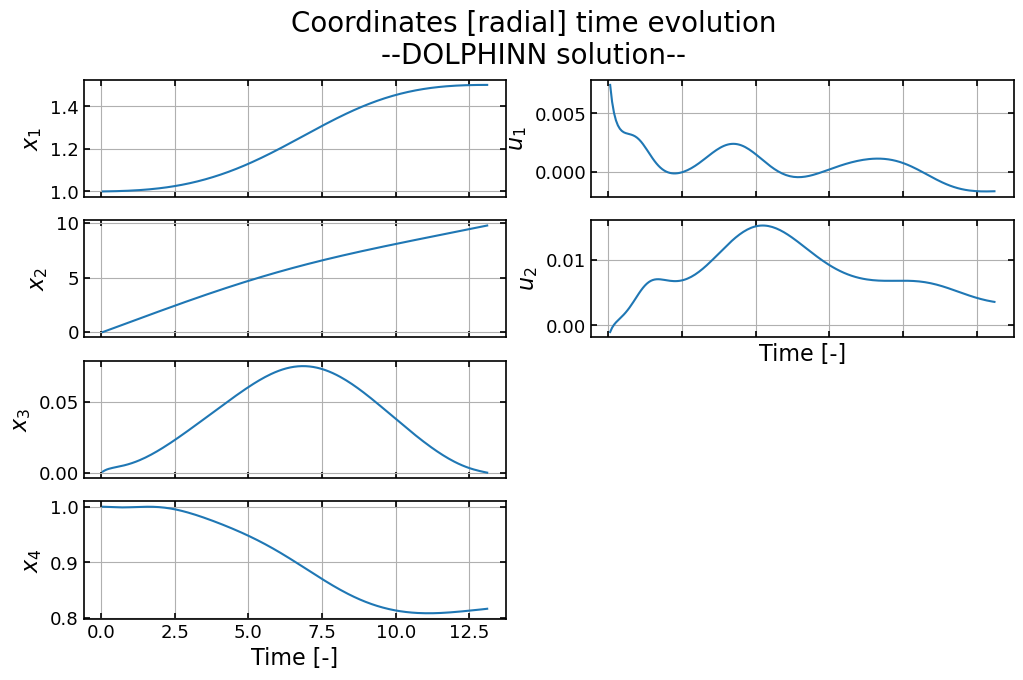

In [17]:
problem.verify()
plotting.plot_loss(problem, objective_zoom=True)  
plotting.plot_transfer(problem, thrust_scale = 0.02, r_target = 1.5, N_arrows = 50)
plotting.compare(problem, 'NDcartesian', log = False)
plotting.plot_coordinates(problem, "radial")

In [13]:
problem.store("../data/Optimisation/LVLH/mars_1_5_revolv2/", overwrite = True)

Saving loss history to ../data/Optimisation/LVLH/mars_1_5_revolv2/loss.dat ...
Saving training data to ../data/Optimisation/LVLH/mars_1_5_revolv2/train.dat ...
Saving test data to ../data/Optimisation/LVLH/mars_1_5_revolv2/test.dat ...
[DOLPHINN] Saving config file to ../data/Optimisation/LVLH/mars_1_5_revolv2/config
